<a href="https://colab.research.google.com/github/ZhongyuGuo/M4R/blob/main/LDA_2cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import re
import random
import torch
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount("/content/drive")
df=pd.read_csv("/content/drive/My Drive/M4R/papers2019_200000.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# List of categories
catlist=['math','cs','quant-ph','hep-ex','hep-th','astro-ph','nucl-ex','nucl-th']

In [4]:
# Categories to classify
cat1=catlist[0]
cat2=catlist[1]

In [5]:
# Obtain corresponding abstarcts
df1=df[df['categories']==cat1][0:1500].reset_index(drop=True)
df2=df[df['categories']==cat2][0:1500].reset_index(drop=True)
text=df1.append(df2).reset_index(drop=True)
df3=df[df['categories']==cat1][1000:1500].reset_index(drop=True)
df4=df[df['categories']==cat2][1000:1500].reset_index(drop=True)
X_test=df3.append(df4).reset_index(drop=True)
#Prepare a column of labels
list1=np.zeros(1500)
list2=np.ones(1500)
y=np.append(list1,list2)
text['y']=y
text=text.sample(frac=1).reset_index(drop=True)

In [6]:
text

,Unnamed: 0,categories,abstracts,year,y
0,2902,math,We describe an algorithm for enumerating the...,2019,0.0
1,1,math,Cofibrations are defined in the category of ...,2019,0.0
2,14570,cs,Object detection and segmentation represents...,2019,1.0
3,21287,cs,This paper proposes a fusion-based gender re...,2019,1.0
4,7023,cs,This paper revisits the solution of the word...,2019,1.0
...,...,...,...,...,...
2995,4171,math,We introduce the concept of topological radi...,2019,0.0
2996,7613,math,Given a reduced alternating diagram for a li...,2019,0.0
2997,7715,math,Let $f$ be a generically finite polynomial m...,2019,0.0
2998,147,math,"In this article, we will prove Riemann Hypot...",2019,0.0


In [7]:
RANDOM_STATE = 50
EPOCHS =15
BATCH_SIZE = 512
TRAINING_LENGTH = 50
TRAIN_FRACTION = 0.7
LSTM_CELLS = 64
VERBOSE = 1
SAVE_MODEL = True

In [8]:
def format_text(text):
    """Add spaces around punctuation and remove references to images/citations."""

    # Add spaces around punctuation
    text = re.sub(r'(?<=[^\s0-9])(?=[.,;?])', r' ', text)

    # Remove meaningless words
    text = re.sub(' the ',' ',text)
    text = re.sub(' of ',' ',text)
    text = re.sub(' and ',' ',text)
    text = re.sub(' a ',' ',text)
    text = re.sub(' in ',' ',text)
    text = re.sub(' to ',' ',text)
    text = re.sub(' with ',' ',text)
    text = re.sub(' for ',' ',text)
    text = re.sub(' by ',' ',text)
    text = re.sub(' on ',' ',text)
    text = re.sub(' as ',' ',text)
    text = re.sub(' an ',' ',text)
    text = re.sub(' at ',' ',text)
    text = re.sub(' we ',' ',text)
    text = re.sub(' is ',' ',text)
    text = re.sub(' this ',' ',text)
    text = re.sub(' are ',' ',text)
    text = re.sub(' which ',' ',text)
    text = re.sub(' be ',' ',text)
    text = re.sub(' it ',' ',text)
    text = re.sub(' that ',' ',text)
    text = re.sub(' from ',' ',text)
    text = re.sub(' can ',' ',text)
    text = re.sub(' these ',' ',text)
    text = re.sub(' our ',' ',text)
    text = re.sub(' has ',' ',text)
    text = re.sub(' have ',' ',text)
    text = re.sub('.We ','.',text)
    text = re.sub('.That ','.',text)
    text = re.sub('.The ','.',text)
    text = re.sub('.From ','.',text)
    text = re.sub('.Our ','.',text)
    text = re.sub('.In ','.',text)
    text = re.sub('.These ','.',text)
    text = re.sub('.This ','.',text)
    text = re.sub(',that ',',',text)
    
    # Remove double spaces
    text = re.sub(r'\s\s', ' ', text)
    
    return text

In [9]:
data_samples = []

# Iterate through all the original abstracts
for a in text['abstracts']:
    data_samples.append(format_text(a))

In [10]:
n_components = 2
n_top_words = 20

# Function to plot the most relevant words
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 2, figsize=(20, 12), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# Use tf (raw term count) features to vectorize the abstacrts for LDA.
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,stop_words='english')
tf = tf_vectorizer.fit_transform(data_samples)

# Fit the LDA model
lda = LatentDirichletAllocation(n_components=n_components,learning_method='batch',doc_topic_prior=5,topic_word_prior=5)
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=5, evaluate_every=-1,
                          learning_decay=0.7, learning_method='batch',
                          learning_offset=10.0, max_doc_update_iter=100,
                          max_iter=10, mean_change_tol=0.001, n_components=2,
                          n_jobs=None, perp_tol=0.1, random_state=None,
                          topic_word_prior=5, total_samples=1000000.0,
                          verbose=0)

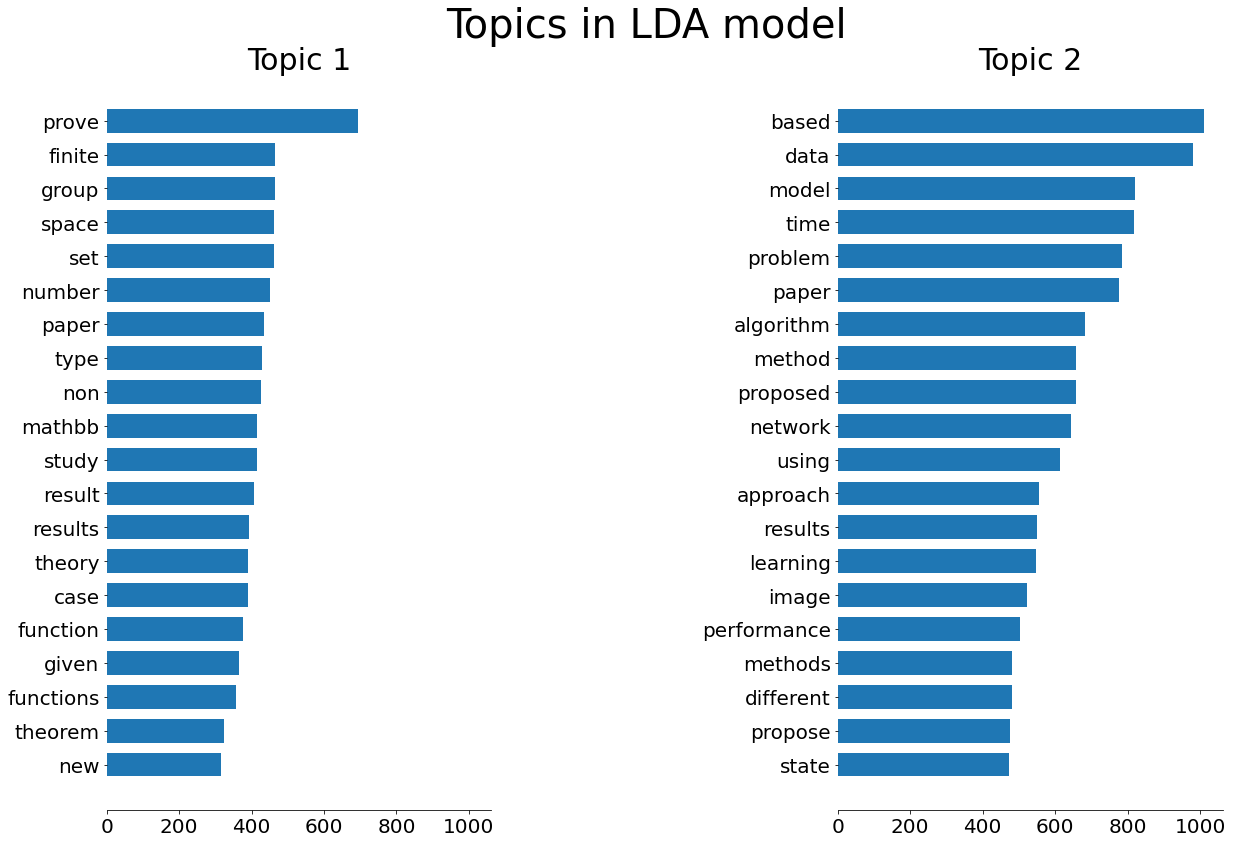

In [11]:
# Plot top words
tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

In [12]:
# Compute test accuracy
from sklearn.metrics import accuracy_score
prob=lda.transform(tf)
pred=prob.argmax(axis=1)
acc=accuracy_score(text['y'],pred)
print(max(acc,1-acc)*100)

88.7


In [13]:
count=0
list1=[]
for i in range(len(prob)):
  list1.append(np.abs(prob[i,0]-prob[i,1]))
ind=list1.index(min(list1))
print(prob[ind,:])

[0.50000684 0.49999316]


In [14]:
print(text.iloc[ind,:])
print(text.iloc[ind,:]['abstracts'])

Unnamed: 0                                                11944
categories                                                   cs
abstracts       Structure editors allow programmers to edit ...
year                                                       2019
y                                                             1
Name: 514, dtype: object
  Structure editors allow programmers to edit the tree structure of a program directly. This can have cognitive benefits, particularly for novice and end-user programmers. It also simplifies matters for tool designers, because they do not need to contend with malformed program text. This paper defines Hazelnut, a structure editor based on a small bidirectionally typed lambda calculus extended with holes and a cursor. Hazelnut goes one step beyond syntactic well-formedness: its edit actions operate over statically meaningful incomplete terms. Naively, this would force the programmer to construct terms in a rigid "outside-in" manner. To avoid this p